In [1]:
from __future__ import annotations

__all__ = ['CircuitAnsatz',
           'IQPAnsatz',
           'Sim4Ansatz',
           'Sim14Ansatz',
           'Sim15Ansatz',
           'StronglyEntanglingAnsatz']

from abc import abstractmethod
from collections.abc import Callable, Mapping
from itertools import cycle
from typing import Type

import numpy as np
from sympy import Symbol, symbols

from lambeq.ansatz import BaseAnsatz
from lambeq.backend.grammar import Box, Diagram, Functor, Ty
from lambeq.backend.quantum import (
    Bra,
    CRz,
    Diagram as Circuit,
    Discard,
    H,
    CX,
    Id,
    Ket,
    quantum,
    qubit,
    Rotation,
    Rx, Ry, Rz
)

from lambeq import AtomicType

'''
We want to understand the DisCoPy side of Lambeq to write an entangling circuit 
'''

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


'\nWe want to understand the DisCoPy side of Lambeq to write an entangling circuit \n'

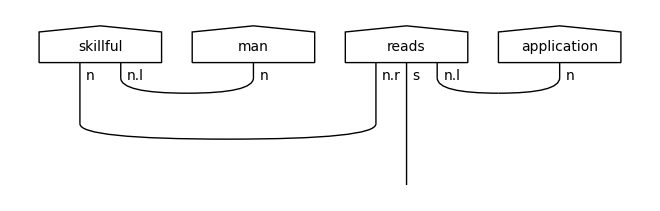

In [2]:
test_data = 'skillful man reads application'


from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_test_diagrams = parser.sentence2diagram(test_data, suppress_exceptions=True)

raw_test_diagrams.draw()

In [19]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq import AtomicType

N = AtomicType.NOUN
S = AtomicType.SENTENCE

n, s = Ty('n'), Ty('s')

# create three functions for three types of diagrams

def GijsDiag(sentence:str): 
    '''
    This function, given a sentence of the form: 
    Subj Verb Obj and Subj* does too
    , returns a diagram that copies the information in such a way that the returned diagram reads: 
    Subj Verb Obj and Subj* Verb Obj
    The object will be removed later to work with density matrices. 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 2, 1) @ Id(n.r) @ Id(s) @ Cup(n.l, n) >> 
            Cup(n, n.r) @ Id(s) )
    newWords = [
        Word(wordList[0], n),
        Word(wordList[4], n),
        Word(wordList[1], n.r @ s @ n.l), 
        Word(wordList[2], n)
    ]

    diagram = Id().tensor(*newWords) >> grammar
    # diagram = remove_cups(diagram)
    diagram.draw()

    circuit = ansatz(diagram= diagram)

    return circuit, diagram 

def NaiveDiag(sentence:str):
    '''
    Simply returns a naive circuit given a diagram
    '''
    diagram = parser.sentence2diagram(sentence= sentence, suppress_exceptions=True)

    diagram = remove_cups(diagram)

    circuit = ansatz(diagram= diagram)

    return circuit, diagram

def AmbiguousVerb(sentence:str):
    '''
    This function, given a sentence like: 
    Subj Verb Obj and Verb* it. (Man prepares dinner and eats it.) 
    returns a diagram that copies the information, so that: 
    Subj Verb Obj and Subj Verb* Obj
    The object will be removed later 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 1, 2) @ Id(n.r) @ Id(s) @ Id(n.l) @ Spider(n, 1, 2)  >> 
                Id(n) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Id(n) >> 
                Id(n) @ Word(wordList[4], n.r @ s @ n.l) @ Id(s) @ Id(n) >> 
                Cup(n, n.r) @ Id(s) @ Swap(n.l, s) @ Id(n) >> 
                Spider(s, 2, 1) @ Cup(n.l, n))
    newWords = [
        Word(wordList[0], n),
        Word(wordList[1], n.r @ s @ n.l),
        Word(wordList[2], n)
    ]


    diagram = Id().tensor(*newWords) >> grammar
    diagram = remove_cups(diagram)
    circuit = ansatz(diagram= diagram)

    return circuit, diagram 




In [36]:
# testCirc, testDiag = NaiveDiag('man prepares food and he eats it')
# testCirc, testDiag = NaiveDiag('Man prepares food and man eats food')
# GisjDiagPrg, testDiag1 = GijsDiag('person prepares meal and programmer does too')
# GisjDiagChef, testDiag1 = GijsDiag('person prepares meal and chef does too')
# GisjDiagPerson, testDiag1 = GijsDiag('person prepares meal and person does too')
# MyDiagCooks, forget = AmbiguousVerb('person prepares meal and cooks it')
# MyDiagBakes, forget = AmbiguousVerb('person prepares meal and bakes it')
# MyDiagRuns, forget = AmbiguousVerb('person prepares meal and runs it')
NaiveDiag1, forget = NaiveDiag('person prepares meal')
# MyDiagPrepares, forget = AmbiguousVerb('person prepares meal and prepares it')
testDiag1, forget = NaiveDiag('person prepares meal and chef prepares meal')
testDiag2, forget = NaiveDiag('person prepares meal and programmer prepares meal')

# NaiveDiagGijs.draw() 

In [38]:
'''
Function to go through the test diagrams one by one 
and modify them accordingly. 
'''
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.converters import dag_to_circuit, circuit_to_dag

def SetUpDiags(circuit: QuantumCircuit, parameterDict: dict, WordsToForget: list = ['woman', 'person', 'meal'], show: bool = False):
    '''
    Given a circuit as an Input, we remove the noun parameters belonging to the first noun in the sentence. 

    We then, depending on the shape of the circuit, replace the noun parameters by an entangled Bell state or we forget about it. 

    In the end, we replace the verb parameters by the parameters learned by the model. 

    The reason we are doing this is to introduce a model with real uncertainty. 

    wordsToForget: list of strings of words that we want to forget ('man', 'woman', 'person', ...)

    '''
    # remove noun parameters and set the rest of the parameters 

    # start by extracting circuit data 
    circuitData = circuit.data

    if show:     
        print('circuit that we start with: ')
        print(circuit)


    # list to store the nounParameters to be removed 
    indexList = []

    # boolean that tells us if the noun of interest is daggered or not 
    dagger = False 

    for i in range(len(circuitData)): 

        # check if this gate has a parameter of a word we want to forget about
        for word in WordsToForget:
            if word in str(circuitData[i].operation.params):
                # store the parameter in a list
                indexList.append(i)

                qubitOfInterest = circuitData[i].qubits[0].index

                if '†' in str(circuitData[i].operation.params):
                    dagger = True 
                    


    # FIRST: UPDATE THE PARAMETERS, THEN REMOVE THE GATES FROM THE CIRCUIT 

    # get parameters of the remaining circuit 
    params = circuit.parameters


    # set the parameters of the remaining words based on the models weights 
    for i in range(len(params)):
        # print(str(params[i]))
        # print(parameterDict[str(params[i])])
        print(params[i])
        if str(params[i]) in parameterDict:
            circuit = circuit.assign_parameters({params[i]: (parameterDict[str(params[i])]/(2*np.pi))})
        else: 
            # if the model only learned parameters for the word that are not daggered
            if '†' in str(params[i]):
               tempParam = str(params[i])
               # reverse string 
               tempParam = tempParam[::-1]

               # remove elements 2,3,4,5
               tempParam = tempParam[:2] + 'n__' + tempParam[5:]

               tempParam = tempParam[::-1]
               print(tempParam)             

               circuit = circuit.assign_parameters({params[i]: (parameterDict[tempParam]/(2*np.pi))}) 

    if show: 
        print('Circuit wiht new parameters: ')
        print(circuit)
    

    # remove the parameters of the words we want to forget
    circuit.data.pop(indexList[0])
    # circuit.data.pop(indexList[1]-1)
    # circuit.data.pop(indexList[2]-2)

    if show: 
        print('circuit with removed words to forget: ')
        print(circuit)


    # if the word we want to forget about is an effect, we simply forget about the qubit 
    if dagger: 
        # remove measurement 
        circuitData = circuit.data

        for i in range(len(circuitData)):

            if str(circuitData[i].operation.name) == 'measure': 
                if circuitData[i].qubits[0].index == qubitOfInterest: 
                    circuit.data.pop(i)
                    break
        
        # that's it 
        

    # if the word we want to forget about is a state, we introduce a bell state and clip it to the beginning of the circuit 
    if not dagger: 
        # introduce circuit with 5 qubits to be composed with the initial circuit 
        bellCircuit = QuantumCircuit(circuit.num_qubits + 1)
        # bell state on first two qubits 
        bellCircuit.h(0)

        # entangle the artificial qubit with the qubit of interest
        bellCircuit.cx(0,qubitOfInterest + 1)

        # now, add one 'artificial' qubit to the initial circuit 
        q = QuantumRegister(1, 'q')
        circuit = circuit.reverse_bits()
        circuit.add_bits(q)
        circuit = circuit.reverse_bits()

        # now that the two circuits are equal in length, combine them 
        circuit = bellCircuit.compose(circuit) #, qubits=[0,1,2,3,4])

        # now, we have our circuit 

    circuit.draw(output= 'mpl', filename='testtest.png')


    return circuit, not dagger


from lambeq import BobcatParser
from lambeq import RemoveCupsRewriter
from lambeq import IQPAnsatz

from pytket.extensions.qiskit import tk_to_qiskit






In [26]:

'''
Now, for the density matrices 
'''
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city



def GetDensityMatrix(circuit: QuantumCircuit, traceList: list, addedQubit: bool):
    '''
    Given a QuantumCircuit representing a sentence, this function returns the density matrix of the *sentence* qubit 
    ''' 
    import qiskit.quantum_info as qi 
    from qiskit.providers.aer import AerSimulator
    
    dmSimulation = AerSimulator()

    job = dmSimulation.run(circuit.decompose(reps = 1))



    result = job.result()

    # print(result)

    data = result.data()

    rho = data.get('density_matrix')

    # print('CIRCUIT IN DENSITY MATRIX')
    # print(circuit)

    # differentiate between dagger and not dagger (one has one qubit less)
    # dagger
    # if circuit.num_qubits == 4: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0, 2, 3])

    # # not dagger 
    # elif circuit.num_qubits == 5: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0, 1, 2, 4])

    # # simple sentence like man prepares food, without any adjectives, man will be daggered there 
    # elif circuit.num_qubits == 3: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0,2])

    if not addedQubit:
        sentenceDM = partial_trace(state=rho, qargs= traceList)
    if addedQubit: 
        traceList = [i+1 for i in traceList]
        traceList.insert(0,0)
        # print('modified tracelist if appended:', traceList)
        sentenceDM = partial_trace(state=rho, qargs= traceList)

    # else: 
    #     print('number of qubits: ', circuit.num_qubits)
    #     print(circuit)

    return sentenceDM



In [27]:
'''
now for the application of the code
'''

def Main(listOfCircuits: list, parameterDict: dict, wordsToForget: list):
    '''
    Iterate over all circuits in the test_circuits list and for each of them create the density matrix as explained above 
    ''' 

    listOfDensityMatrices: list = []


    from pytket.extensions.qiskit import tk_to_qiskit

    numQubitsList: list = []

    for i in range(len(listOfCircuits)): 

        print('iteration number: ', i)

        tempCirc = listOfCircuits[i]

        # if i == 8: 
        #     tempCirc.draw()

        tempCircTK = tempCirc.to_tk()

        tempCircQiskit = tk_to_qiskit(tempCircTK)

        # if i == 8: 
        #     print(tempCircQiskit)

        circuitData = tempCircQiskit.data

        # list of qubits that shall be forgotten when traced over
        traceList = []
        for i in range(len(circuitData)):
            if str(circuitData[i].operation.name) == 'measure':
                traceList.append(circuitData[i].qubits[0].index)
        # print('traceList: ', traceList)

        alteredTempCirc, addedQubit = SetUpDiags(tempCircQiskit, parameterDict, wordsToForget)

        # to access density matrix later on 
        alteredTempCirc.save_density_matrix() 

        densityMatrix = GetDensityMatrix(alteredTempCirc, traceList, addedQubit) 
        
        listOfDensityMatrices.append(densityMatrix)

        numQubitsList.append(tempCircQiskit.num_qubits)

    return listOfDensityMatrices, numQubitsList
    





In [32]:
# one of these two is wordsToForget
wordsToForgetSubj = ['man', 'woman', 'person']
wordsToForgetObj  = ['dinner', 'meal', 'sauce', 'program', 'application', 'software']

# load dictionary with pickle
import pickle 

# Numpymodel 
with open('../datasets/weightsDictNPGijs.pkl', 'rb') as fp: 
    parameterDictNP = pickle.load(fp)

# Numpymodel 
with open('../code/weightsDictNP.pkl', 'rb') as fp: 
    parameterDictNP = pickle.load(fp)

# Pennylane model 
with open('../code/weightsDictPL.pkl', 'rb') as fp: 
    parameterDictPL = pickle.load(fp)

# TKet model 
with open('../code/weightsDictTK.pkl', 'rb') as fp: 
    parameterDictTKold = pickle.load(fp)



# Numpymodel 
with open('../datasets/weightsDictNPGijs2QB.pkl', 'rb') as fp: 
    parameterDictNP = pickle.load(fp)

# Pennylane model 
with open('../datasets/weightsDictPLGijs2QB.pkl', 'rb') as fp: 
    parameterDictPL = pickle.load(fp)

# TKet model 
with open('../datasets/weightsDictTKGijs2QB.pkl', 'rb') as fp: 
    parameterDictTK = pickle.load(fp)

print(parameterDictTKold)
print(parameterDictTK)
print()

{'application__n_0': 0.9272364606209574, 'application__n_1': -0.013606311619775725, 'application__n_2': 1.4901902035599754, 'application†_n__0': -0.7495831907005022, 'application†_n__1': -1.4875241187074695, 'application†_n__2': 0.5480365694724486, 'bakes__n.r@s@n.l_0': 1.0202564039521487, 'bakes__n.r@s@n.l_1': 2.1740604840715037, 'cooks__n.r@s@n.l_0': -0.8552840715132274, 'cooks__n.r@s@n.l_1': -0.07183544242920739, 'dinner__n_0': 0.3921443375883134, 'dinner__n_1': 1.0532114754288195, 'dinner__n_2': 0.9294310511112133, 'dinner†_n__0': 1.6866690504129247, 'dinner†_n__1': 0.20751309123185058, 'dinner†_n__2': 2.1429014182899917, 'man__n_0': 0.4968541136348181, 'man__n_1': -0.1084618847079396, 'man__n_2': -0.9960665261711695, 'man†_n__0': 1.9646941692837954, 'man†_n__1': 0.5080914245066241, 'man†_n__2': 4.323060317661385, 'meal__n_0': 1.9388276250029877, 'meal__n_1': 0.04669379791635835, 'meal__n_2': -0.8182376160302048, 'meal†_n__0': 0.733665850015535, 'meal†_n__1': -1.3602736094386574, '

In [39]:

# dm1, nQ1 = Main(listOfCircuits= [GisjDiagPerson], parameterDict= parameterDictTK, wordsToForget=['meal'])
# dm2, nQ2 = Main(listOfCircuits= [GisjDiagChef], parameterDict= parameterDictTK, wordsToForget=['meal'])
# dm3, nQ3 = Main(listOfCircuits= [GisjDiagPrg], parameterDict= parameterDictTK, wordsToForget=['meal'])
print('gijsdiags done. ')

dm4, nQ4 = Main(listOfCircuits= [NaiveDiag1], parameterDict= parameterDictTK, wordsToForget=['meal'])

dmtest, nQ4 = Main(listOfCircuits= [testDiag1], parameterDict= parameterDictTK, wordsToForget=['meal'])
dmtest1, nQ4 = Main(listOfCircuits= [testDiag2], parameterDict= parameterDictTK, wordsToForget=['meal'])

# dm8, nQ8 = Main(listOfCircuits= [NaiveDiagGijs], parameterDict= parameterDictNP, wordsToForget=['meal'])
print('naive diag done. ')

# dm8, nQ8 = Main(listOfCircuits= [MyDiagPrepares], parameterDict= parameterDictTK, wordsToForget=['meal'])

# dm5, nQ5 = Main(listOfCircuits= [MyDiagBakes], parameterDict= parameterDictTK, wordsToForget=['meal'])
# dm6, nQ6 = Main(listOfCircuits= [MyDiagCooks], parameterDict= parameterDictTK, wordsToForget=['meal'])
# dm7, nQ7 = Main(listOfCircuits= [MyDiagRuns], parameterDict= parameterDictTK, wordsToForget=['meal'])

gijsdiags done. 
iteration number:  0
meal†_n__0
person†_n__0
prepares__n.r@s@n.l_0
prepares__n.r@s@n.l_1
prepares__n.r@s@n.l_2
prepares__n.r@s@n.l_3


/tmp/ipykernel_470/3272665932.py:39: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  traceList.append(circuitData[i].qubits[0].index)
/tmp/ipykernel_470/2979185679.py:46: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubitOfInterest = circuitData[i].qubits[0].index
/tmp/ipykernel_470/2979185679.py:104: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qisk

iteration number:  0
and__s.r@s@s.l_0
and__s.r@s@s.l_1
chef__n_0
meal__n_0
person__n_0
prepares†_n.r@s@n.l__0
prepares†_n.r@s@n__n_0


KeyError: 'prepares†_n.r@s@n__n_0'

In [ ]:
from qiskit.quantum_info import entropy

# print('person prepares ? and person does too: ', entropy(dm1[0]))
# print('person prepares ? and chef does too: ', entropy(dm2[0]))
# print('person prepares ? and programmer does too: ', entropy(dm3[0]))

print('person prepares ?: ', entropy(dm4[0]))
# print('person prepares ? and chef does too, naive! : ', entropy(dm8[0]))

print('person prepares ? and bakes it: ', entropy(dm5[0]))
print('person prepares ? and cooks it: ', entropy(dm6[0]))
print('person prepares ? and runs it: ', entropy(dm7[0]))
print('person prepares ? and prepares it: ', entropy(dm8[0]))

person prepares ?:  0.8563875680360614
person prepares ? and bakes it:  0.9009506383922472
person prepares ? and cooks it:  0.4353378933355817
person prepares ? and runs it:  0.7827995380270132
person prepares ? and prepares it:  0.9277812757842117


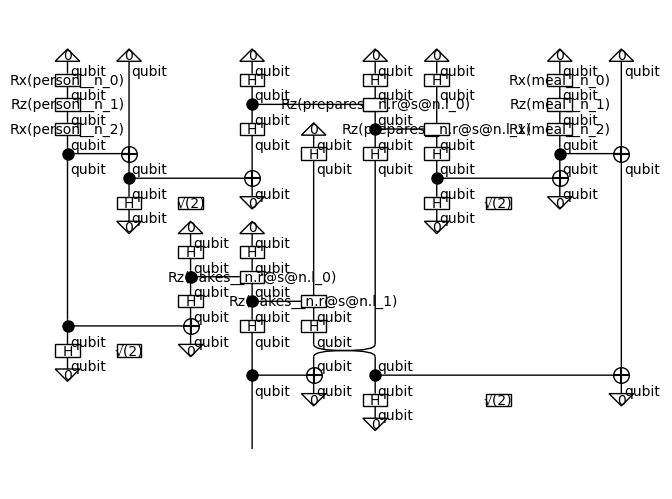

In [ ]:
MyDiagBakes.draw() 

In [ ]:
entropyNPSubj: list = []
entropyNPObj: list = []
entropyPLSubj: list = []
entropyPLObj: list = []
entropyTKSubj: list = []
entropyTKObj: list = []

for i in range(len(dmListNPSubj)):
    entropyNPSubj.append(entropy(dmListNPSubj[i]))
    entropyNPObj.append(entropy(dmList2[i]))
    entropyPLObj.append(entropy(dmList3[i]))


NameError: name 'dmListNPSubj' is not defined

In [ ]:
print(entropyNPSubj)
print(entropyNPObj)
print(entropyPLObj)

[0.014893890803028664]
[0.9905346865047184]
[0.988184116683595]
